In [146]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from collections import defaultdict, Counter
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

# Model imports
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [147]:
with open('final_df.pickle','rb') as f:
    df = pickle.load(f)

In [148]:
df.head()

,ELEVATION,precip_num_days_over_0.01,precip_num_days_over_0.1,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp,high_incidence
0,100.300000,120.000000,62.000000,14.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082,0
1,107.300000,91.000000,74.000000,20.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082,0
2,103.800000,106.000000,74.500000,16.5,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082,0
3,31.723077,111.090909,75.909091,21.0,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000,0
4,29.991667,95.300000,64.500000,14.1,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333,0


## Detecting Class Imbalance
- There is a large class imbalance issue with this data
- I will experiment with undersampling and oversampling to see if they will improve model performance

In [149]:
# Observing Large Class Imbalance
df.high_incidence.value_counts()/len(df)

0    0.857209
1    0.142791
Name: high_incidence, dtype: float64

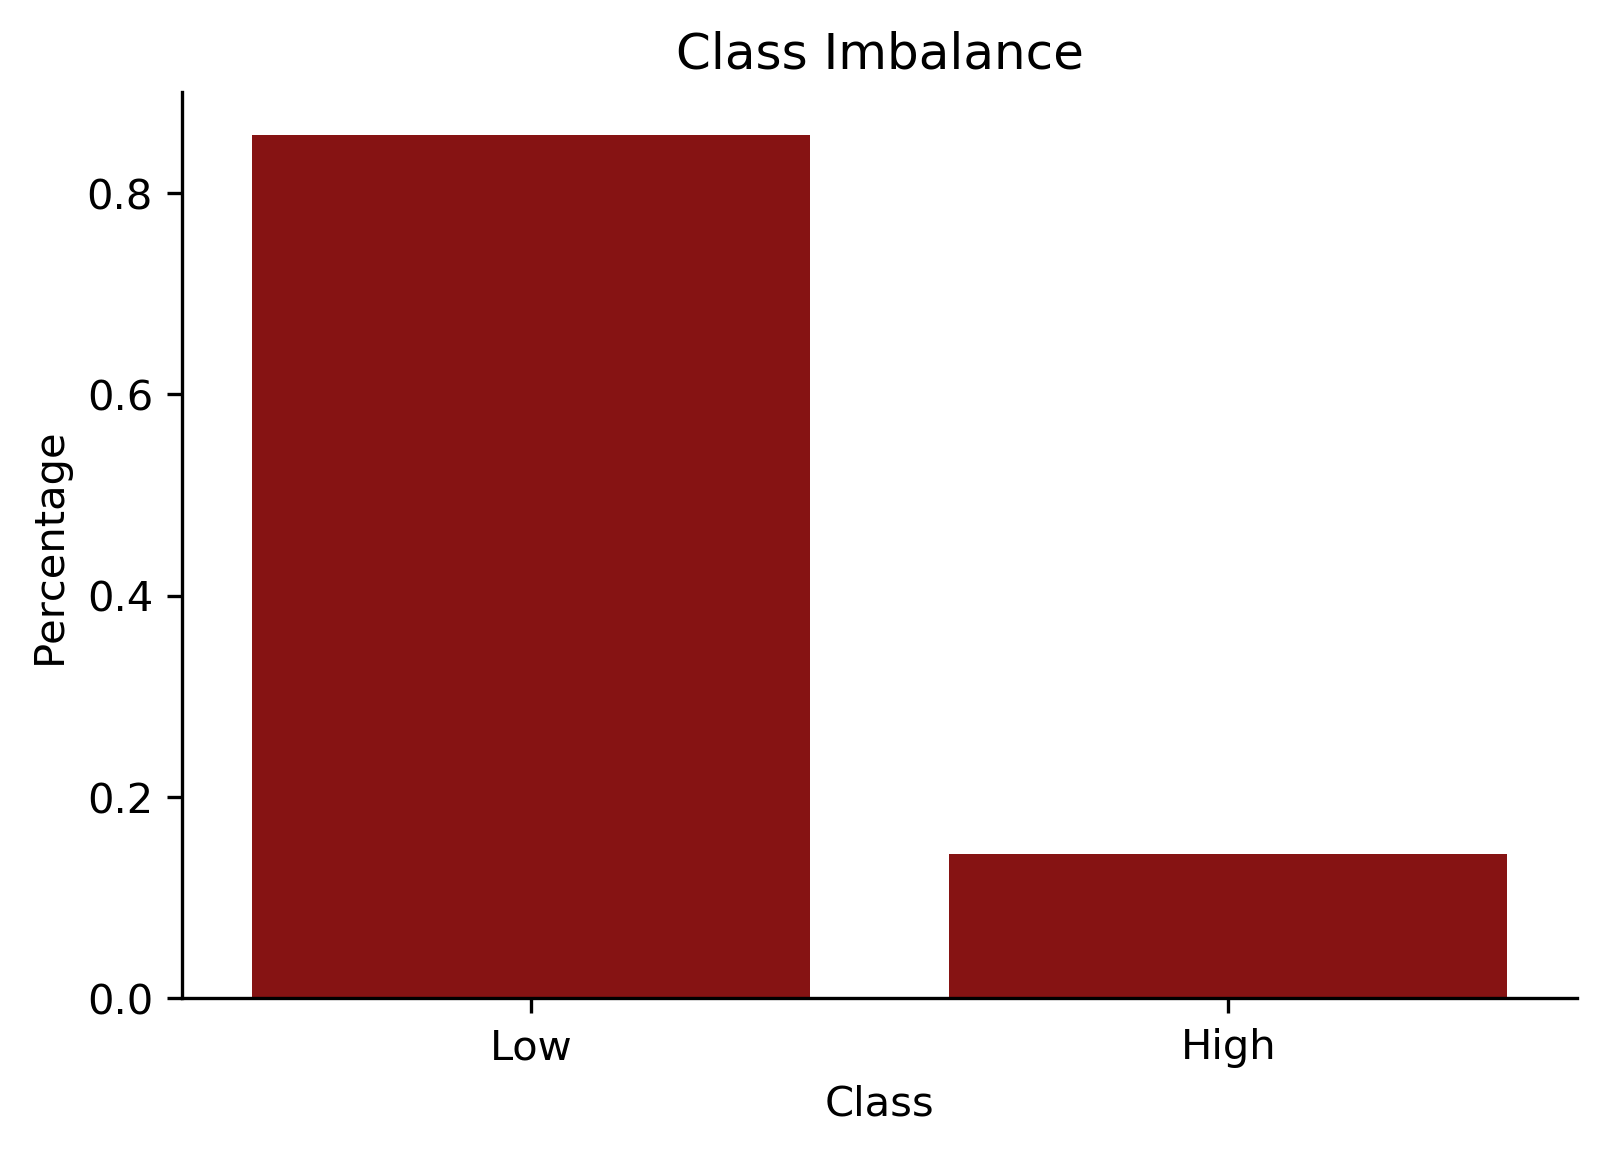

In [150]:
# Plotting Class Imbalance 
plt.figure(dpi=300)
sns.barplot(['Low', 'High'], df.high_incidence.value_counts()/ len(df), color='#990000ff')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Imbalance')

sns.despine()

## Modeling

### Test-Validation-Train Splits

In [151]:
# Splitting data into feature variables
X = df.iloc[:,:-1]
# and target variable
y = df.iloc[:,-1]

In [152]:
# Test-Validation-Train Split (60-20-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42,stratify=y_test)

In [153]:
# Verifying Correct Percentages
print('Training Set:',len(X_train)/len(X))
print('Validation Set:',len(X_val)/len(X))
print('Test Set:',len(X_test)/len(X))

Training Set: 0.5999816168022427
Validation Set: 0.20000919159887862
Test Set: 0.20000919159887862


### Standardized Splits for Linear Models

In [37]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)

### Oversampling/ Undersampling Splits

In [44]:
# Ratio of zeros(low incidence counties) to 
# ones(high incidence counties) before resampling
Counter(y_train)

Counter({0: 11191, 1: 1864})

In [38]:
# Random Oversampling of high incidence rows
# and resulting ratio
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_scaled_train,y_train) # 
Counter(y_resampled)

Counter({0: 11191, 1: 11191})

In [39]:
# SMOTE Oversampling of high incidence rows
# and resulting ratio
smo = SMOTE(random_state=42)
X_smoted, y_smoted = smo.fit_sample(X_train,y_train)
X_scaled_smoted, y_scaled_smoted = smo.fit_sample(X_scaled_train,y_train)
Counter(y_smoted)

Counter({0: 11191, 1: 11191})

In [57]:
# ADASYN Oversampling of high incidence rows
# and resulting ratio
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_sample(X_train,y_train)
X_scaled_adasyn, y_scaled_adasyn = ada.fit_sample(X_scaled_train,y_train)
print(Counter(y_adasyn))
print(Counter(y_scaled_adasyn))

Counter({0: 11191, 1: 11082})
Counter({0: 11191, 1: 11173})


In [41]:
# Random Undersampling of high incidence rows
# and resulting ratio
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_sample(X_train,y_train)
X_scaled_under, y_scaled_under = rus.fit_sample(X_scaled_train,y_train)
Counter(y_under)

Counter({0: 1864, 1: 1864})

In [42]:
# Creating lists of different splits for grid searching
train_sets = [(X_train, y_train),(X_resampled, y_resampled),
              (X_smoted, y_smoted),(X_adasyn, y_adasyn),(X_under, y_under)]

scaled_train_sets = [(X_scaled_train, y_train),(X_scaled_resampled, y_scaled_resampled),
              (X_scaled_smoted, y_scaled_smoted),(X_scaled_adasyn, y_scaled_adasyn),(X_scaled_under, y_scaled_under)]

### K-Nearest Neighbors

In [62]:
### Manual Cross Fold Validation for Hyper Parameter Tuning- KNN
knn_train_set_results = []
for features, target in scaled_train_sets:
    k_range = range(1,40)
    all_scores = []
    for x in k_range:
        print(x)
        knn = KNeighborsClassifier(n_neighbors=x)
        scores = cross_val_score(knn, features, target, cv=5, scoring='roc_auc', n_jobs=-1)
        all_scores.append(np.mean(scores))
    best_index = np.argmax(all_scores)
    print(f'The best hyper parameters are: {k_range[best_index]}')
    print(f'The best score is: {all_scores[best_index]}')
    knn_train_set_results.append({(k_range[best_index],all_scores[best_index], best_index):all_scores})

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
The best hyper parameters are: 15
The best score is: 0.9199238920716623
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
The best hyper parameters are: 2
The best score is: 0.9594359808959055
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
The best hyper parameters are: 9
The best score is: 0.9694474232728503
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
The best hyper parameters are: 8
The best score is: 0.9470770403987231
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
The best hyper parameters are: 11
The best score is: 0.9116374246437928


In [69]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_scaled_smoted, y_scaled_smoted)
y_pred = knn.predict_proba(X_scaled_val)[:,1]
# knn_fpr, knn_tpr, _ = metrics.roc_curve(y_val,y_pred)
# plt.plot(knn_fpr,knn_tpr)

In [70]:
metrics.roc_auc_score(y_val,y_pred)

0.9004676603191297

In [73]:
grid.best_score_

0.9184986595174263

In [78]:
# Correct steps for KNN
knn_steps = [('scaler', StandardScaler()), ('KNN', KNeighborsClassifier(random_state=42))]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(knn_steps) # define the pipeline object.

knn_parameters = {'KNN__n_neighbors':[x for x in range(1,40)]}

knn_grid = GridSearchCV(pipeline, param_grid=knn_parameters, cv=5, n_jobs=-1, verbose=1)

knn_grid.fit(X_train, y_train)
print(f'score = {knn_grid.score(X_val,y_val)}')
print(knn_grid.best_params_)

Fitting 5 folds for each of 39 candidates, totalling 195 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:  6.1min finished


score = 0.9034926470588235
{'KNN__n_neighbors': 9}


In [79]:
knn_grid.best_score_

0.9085407889697434

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [ ]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

### SVM

In [ ]:
# Example parameters for SVC
parameters = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

In [72]:
# Correct steps for SVC

svm_steps = [('scaler', StandardScaler()), ('SVM', SVC(random_state=42))]

from sklearn.pipeline import Pipeline
svm_pipeline = Pipeline(svm_steps) # define the pipeline object.

svm_parameters = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_parameters, cv=5, n_jobs=-1, verbose=1)

svm_grid.fit(X_train, y_train)
print("score = %3.2f"svm_grid.score(X_val,y_val)))
print(svm_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


score = 0.92
{'SVM__C': 100, 'SVM__gamma': 0.01}


### Logistic Regression

In [125]:
# Generalizable logistic regression code
lr_steps_list = [[('scaler', StandardScaler()),('LR', LogisticRegression(random_state=42))],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler(random_state=42)),
                  ('LR', LogisticRegression(random_state=42))],
                 [('scaler', StandardScaler()), ('smote',SMOTE(random_state=42)),
                  ('LR', LogisticRegression(random_state=42))],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN(random_state=42)),
                  ('LR', LogisticRegression(random_state=42))],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler(random_state=42)),
                  ('LR', LogisticRegression(random_state=42))]
                ]
lr_grid_search_results = []
for lr_steps in lr_steps_list:
    lr_pipeline = Pipeline(lr_steps) # define the pipeline object.

    lr_parameters = {'LR__C':[x for x in np.logspace(-3,3,7)], 'LR__penalty':['l1','l2']}

    lr_grid = GridSearchCV(lr_pipeline, param_grid=lr_parameters, cv=5, n_jobs=-1, verbose=10, scoring='roc_auc')

    lr_grid.fit(X_train, y_train)
    print(lr_grid.best_score_)
    print(lr_grid.best_params_)
    
    lr_grid_search_results.append(lr_grid)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   11.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   15.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.6s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9076847092923175
{'LR__C': 1.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1926s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  31 out of  70 | elapsed:    2.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   19.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9060601064165223
{'LR__C': 1.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   10.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   13.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9057847097864862
{'LR__C': 1.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   27.4s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   34.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   37.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9035160215033012
{'LR__C': 0.1, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1838s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9037410466992241
{'LR__C': 10.0, 'LR__penalty': 'l1'}


In [144]:
# Returning hyperparameters and resampling used in best lr model
lr_score_list = [x.best_score_ for x in lr_grid_search_results]
best_lr_model = lr_grid_search_results[best_lr_model_ix]
print('Hyperparameters:',best_lr_model.best_params_)
best_lr_model_ix = lr_score_list.index(max(lr_score_list))
print('Tranformations/Resampling:',lr_steps_list[best_lr_model_ix])

Hyperparameters: {'LR__C': 1.0, 'LR__penalty': 'l1'}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]


Out of Sample R2 score = 0.9071174883408188


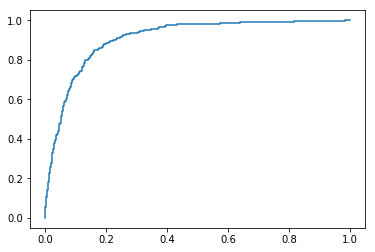

In [143]:
# Finding True Positive Rate and 
# False Positive Rate of Best LR Model

y_pred = best_lr_model.predict_proba(X_val)
print(f'Out of Sample R2 score = {lr_grid.score(X_val,y_val)}') metric
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y_val,[x[1] for x in y_pred])
plt.plot(lr_fpr, lr_tpr);

### Generalizable Function for all model grid searches

In [162]:
np.random.seed(42) 

In [156]:
def complete_grid_search(X_train, y_train, steps_list, param_grid):
    ''' This function does a grid search with cross validation for
    every combination of hyperparameters and resampling techniques.
    
    Input:
    X_train = DataFrame of features in training split
    
    y_train = Series of target variable in training split
    
    steps_list = List of lists of Imblearn pipeline steps
                 Ex: [[('scaler', StandardScaler()),('LR', LogisticRegression())],
                      [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                       ('LR', LogisticRegression())]
                 
    param_grid = Dictionary of hyperparameters to grid search. Keys are labels for 
                 each hyperparameter and Values are ranges for each hyperparameter.
                 Ex: {'LR__C':[x for x in np.logspace(-3,3,7)], 'LR__penalty':['l1','l2']}
    Output:
    Returns a list of the best model for each set of pipeline steps in steps_list.
    '''
    
    grid_search_results = []
    for steps in steps_list:
        pipeline = Pipeline(steps)

        grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10, scoring='roc_auc')

        grid.fit(X_train, y_train)
        
        print(grid.best_score_)
        print(grid.best_params_)

        grid_search_results.append(grid)

    return grid_search_results

In [192]:
def best_model_finder(grid_search_results, steps_list):
    ''' This function finds the best model out of all 
    the grid searches from the complete_grid_search function.
    
    Input:
    grid_search_results = Output of complete_grid_search function(list of models)
    
    steps_list = List of lists of Imblearn pipeline steps
                 Ex: [[('scaler', StandardScaler()),('LR', LogisticRegression())],
                      [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                       ('LR', LogisticRegression())]
                       
    Output:                   
    Returns the best model and prints the hyperparameters
    and resampling techniques for that best model.
    '''
    
    # Finds best scores for each grid search
    score_list = [x.best_score_ for x in grid_search_results]
    
    # finds best model out of all grid searches
    best_model_ix = score_list.index(max(score_list))
    best_model = grid_search_results[best_model_ix]

    print('Hyperparameters:',best_model.best_params_)
    print('Tranformations/Resampling:',steps_list[best_model_ix])
    
    return best_model

In [216]:
def roc_curve_calculator(model, X, y):
    ''' Calculates the roc curve for a given model and data inputs.
    
    Inputs:
    model = any kind of model
    X = features DataFrame
    y = target Series
    
    Output:
    Returns the false positive rate and true positive rate
    for all thresholds and the ROC AUC score.   
    '''
    # Determining model predictions
    y_predictions = [pred[1] for pred in model.predict_proba(X)]
    
    # Calculating fpr and tpr for all thresholds
    fpr, tpr, _ = metrics.roc_curve(y,y_predictions)
    
    # Finding ROC AUC Score
    roc_auc = metrics.roc_auc_score(y,y_predictions)
    print('ROC AUC Score on Unseen Data:',roc_auc)
          
    return fpr, tpr, roc_auc

In [187]:
lr_steps_list = [[('scaler', StandardScaler()),('LR', LogisticRegression())],
                 [('scaler', StandardScaler()), ('ros', RandomOverSampler()),
                  ('LR', LogisticRegression())],
                 [('scaler', StandardScaler()), ('smote',SMOTE()),
                  ('LR', LogisticRegression())],
                 [('scaler', StandardScaler()), ('adasyn',ADASYN()),
                  ('LR', LogisticRegression())],
                 [('scaler', StandardScaler()), ('rus',RandomUnderSampler()),
                  ('LR', LogisticRegression())]]

lr_parameters = {'LR__C':[x for x in np.logspace(-3,3,7)], 'LR__penalty':['l1','l2']}

In [188]:
lr_grid_search_results = complete_grid_search(X_train, y_train, lr_steps_list, lr_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   10.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   14.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.907686697638803
{'LR__C': 10.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   10.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   13.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9062298456759007
{'LR__C': 100.0, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   11.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   13.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.4s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9061375714549996
{'LR__C': 1.0, 'LR__penalty': 'l2'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   25.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   31.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   36.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9036816092248297
{'LR__C': 0.1, 'LR__penalty': 'l1'}
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1570s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s


0.905660991689342
{'LR__C': 100.0, 'LR__penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [193]:
lr_best_model = best_model_finder(lr_grid_search_results, lr_steps_list)

Hyperparameters: {'LR__C': 10.0, 'LR__penalty': 'l1'}
Tranformations/Resampling: [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]


In [218]:
lr_fpr, lr_tpr, lr_val_score = roc_curve_calculator(lr_best_model, X_val, y_val)

ROC AUC Score on Unseen Data: 0.9082325457100249
